In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [12]:
TRAIN_PATH = "train.csv"   
TEST_PATH = "test.csv"     # optional; we will use a held-out split from train.csv
NROWS = 5000               # start out with less!
RANDOM_SEED = 42
PRIMARY_LABEL = "toxic"    # which label column to use for the binary classification task -- seemed relevant
TFIDF_MAX_FEATURES = 5000

# Load dataset
train_df = pd.read_csv(TRAIN_PATH, nrows=NROWS, header=0, index_col="id")
print("Loaded train_df shape:", train_df.shape)
print(train_df.columns)

# Quick dataset description for the report
print("Label distribution (counts):")
print(train_df[PRIMARY_LABEL].value_counts())

# Preprocess features & labels
# Remove rows with missing comment_text
train_df = train_df.dropna(subset=["comment_text"])
X_raw = train_df["comment_text"].astype(str)
y = train_df[PRIMARY_LABEL].astype(int)

# Train/test split
# Use stratified split to keep class balance
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

Loaded train_df shape: (5000, 7)
Index(['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')
Label distribution (counts):
toxic
0    4497
1     503
Name: count, dtype: int64



KNN | Acc: 0.932 | F1: 0.547 | Prec: 0.837 | Rec: 0.406

Classification report:
              precision    recall  f1-score   support

   Non-toxic       0.94      0.99      0.96       899
       Toxic       0.84      0.41      0.55       101

    accuracy                           0.93      1000
   macro avg       0.89      0.70      0.75      1000
weighted avg       0.93      0.93      0.92      1000



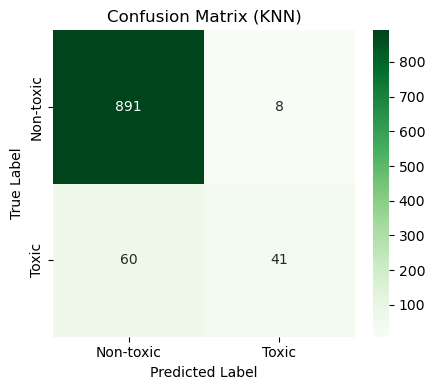

In [18]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=TFIDF_MAX_FEATURES)
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

# Models we tried! 
#model_name = "Logistic Regression"
#clf = LogisticRegression(max_iter=200, solver="liblinear", random_state=RANDOM_SEED)

#model_name = "Naive Bayes"
#clf = MultinomialNB()

## ✨Chosen One✨ ## 
model_name = "KNN"
clf = KNeighborsClassifier(n_neighbors=5, metric="cosine", n_jobs=-1)

# Training model
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, zero_division=0)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)

# Results summary
print(f"\n{model_name} | Acc: {acc:.3f} | F1: {f1:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["Non-toxic", "Toxic"], zero_division=0))

# Conf Matrix 
plt.figure(figsize=(4.5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d",
            cmap="Greens" if model_name == "KNN" else "Blues",
            xticklabels=["Non-toxic", "Toxic"], yticklabels=["Non-toxic", "Toxic"])
plt.title(f"Confusion Matrix ({model_name})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
